## Introduction

This Notebook contains full comments on the code developed to simulate and reproduce the results in the documented example in Chapter 3 of Andreas Juhl Sørensen's Master's thesis.

For full context, refer to the thesis.

Last updated: 28/10/2024

## References
The documented example is:

[1] Kondili, E., et al. “A General Algorithm for Short-Term Scheduling of Batch Operations—I. MILP Formulation.” Computers and Chemical Engineering, vol. 17, no. 17, 1989, pp. 211–27, https://doi.org/10.1016/0098-1354(93)80015-F.

Pyomo guides and documentation can be found at:

[2] Sandia National Laboratories: "Pyomo Documentation 6.8.0", https://pyomo.readthedocs.io/en/stable/#, Date Accessed: 29/10/2024

[3] Bynum, Michael L., et al. “Pyomo — Optimization Modeling in Python.” Pyomo — Optimization Modeling in Python, Springer International Publishing, 2021.

[4] Kanter, Jeffrey C. "ND Pyomo Cookbook", https://jckantor.github.io/ND-Pyomo-Cookbook/README.html, Date Accessed: 29/10/2024

# Prerequisites

This code was developed for Python version 3.12.6 and Pyomo 6.8.0.

In order to simulate the documented example in Python and the Pyomo-extension, the following python packages need to be pre-installed:
1. pyomo
2. matplotlib

These can be installed by running the following commands in a command line (cmd on Windows, terminal on macOS or Linux):

1. pip install pyomo
2. pip install matplotlib

, or the following commands in a Python console of a pre-installed IDE:

1. !pip install pyomo
2. !pip install matplotlib

The following code imports the installed packages mentioned above as well as "numpy", which is built-in for Python distributions.

In [1]:
# Literature Case Study
# MILP Script
# Author: Andreas Juhl Sørensen
# 2024

# %%

#Import PYOMO
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

#Import packages for data and visualisation
import matplotlib.pyplot as plt
import numpy as np

## System Setup

The system is defined based on the STN representation for the example system.

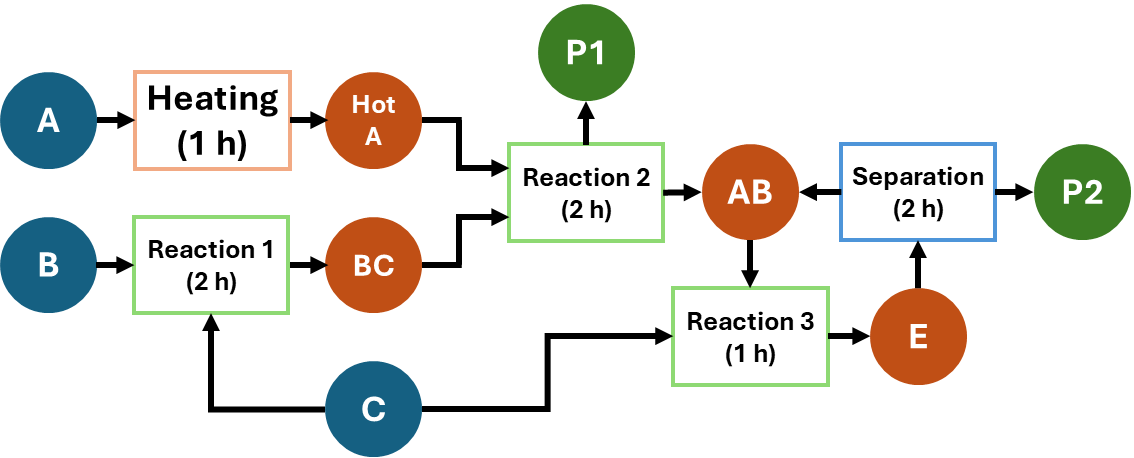

__In the following the connected data to the STN representation above is presented__

The recipes are:
- __Heating__ releases the intermediate ”Hot A” after heating feed A for 1 hour
- __Reaction 1__ consumes 50% feed B and 50% feed C and releases intermediate BC after 2 hours of reaction.
- __Reaction 2__ consumes 40% ”Hot A” and 60% intermediate BC and releases 60% intermediate AB and 40% product 1 after 2 hours of reaction.
- __Reaction 3__ consumes 20% feed C and 80% intermediate AB and releases intermediate E after 1 hour of reaction.
- __Separation__ consumes intermediate E and releases 90% product 2 after 1 hour and 10% intermediate AB after 2 hours by distillation.

The following equipment is available:
- __A heater__ is available for the heating task and has a capacity of 100 kg.
- __Reactor 1__ can facilitate reactions 1, 2 and 3 and has a capacity of 80 kg.
- __Reactor 2__ can facilitate reactions 1, 2 and 3 and has a capacity of 50 kg.
- __A still__ is available for the separation task and has a capacity of 200 kg

The storage capacities are:
- __Feeds A, B and C, and products 1 and 2__ have unlimited capacity.
- __Hot A and E__ have a capacity of 100 kg.
- __AB__ has a capacity of 200 kg.
- __BC__ has a capacity of 150 kg.

In the code below, this data is stored in dictionaries in a general way, whereas the rest of the code only uses the defined dictionaries, so that if the dictionaries are changed to a different system, the code should still work. The states, units and tasks are stored in the following manner: 

In [2]:
##DICTIONARIES are created to carry data in a transparent and general manner
#States (as K for material)
K = {
        'A':   {'Cap': 500, 'Ini': 500, 'nu':  0},
        'B':   {'Cap': 500, 'Ini': 500, 'nu':  0},
        'C':   {'Cap': 500, 'Ini': 500, 'nu':  0},
        'HotA': {'Cap': 100, 'Ini':   0, 'nu': -1},
        'AB':   {'Cap': 200, 'Ini':   0, 'nu': -1},
        'BC':   {'Cap': 150, 'Ini':   0, 'nu': -1},
        'E':    {'Cap': 100, 'Ini':   0, 'nu': -1},
        'P1':   {'Cap': 500, 'Ini':   0, 'nu': 10},
        'P2':   {'Cap': 500, 'Ini':   0, 'nu': 10},
    }

#State-to-Task nodes with feed amount/stoichiometry (as KtI for material to task)
KtI = {
        ('A',   'Heating'):    {'xi': 1.0},
        ('B',   'R1'):         {'xi': 0.5},
        ('C',   'R1'):         {'xi': 0.5},
        ('C',   'R3'):         {'xi': 0.2},
        ('HotA', 'R2'):         {'xi': 0.4},
        ('AB',   'R3'):         {'xi': 0.8},
        ('BC',   'R2'):         {'xi': 0.6},
        ('E',    'Separation'): {'xi': 1.0},
    }

#Task-to-State nodes with task processing time and conversion coefficient
ItK = {
        ('Heating', 'HotA'):  {'tau': 1, 'rho': 1.0},
        ('R2', 'P1'):         {'tau': 2, 'rho': 0.4},
        ('R2', 'AB'):         {'tau': 2, 'rho': 0.6},
        ('R1', 'BC'):         {'tau': 2, 'rho': 1.0},
        ('R3', 'E') :         {'tau': 1, 'rho': 1.0},
        ('Separation', 'AB'): {'tau': 2, 'rho': 0.1},
        ('Separation', 'P2'): {'tau': 1, 'rho': 0.9},
    }

#Units able to perform specific tasks node (as JI_union) with capacity
#and gamma of performing task
JI_union = {
        ('Heater', 'Heating'):    {'Betamin': 0, 'Betamax': 100, 'gamma': 0.01},
        ('Reactor 1', 'R1'):       {'Betamin': 0, 'Betamax':  80, 'gamma': 0.01},
        ('Reactor 1', 'R2'):       {'Betamin': 0, 'Betamax':  80, 'gamma': 0.01},
        ('Reactor 1', 'R3'):       {'Betamin': 0, 'Betamax':  80, 'gamma': 0.01},
        ('Reactor 2', 'R1'):       {'Betamin': 0, 'Betamax':  50, 'gamma': 0.01},
        ('Reactor 2', 'R2'):       {'Betamin': 0, 'Betamax':  50, 'gamma': 0.01},
        ('Reactor 2', 'R3'):       {'Betamin': 0, 'Betamax':  50, 'gamma': 0.01},
        ('Still', 'Separation'):  {'Betamin': 0, 'Betamax': 200, 'gamma': 0.01},
    }

## System Initialisation

Using the dictionaries, relevant sets are defined in a general manner.

### Definition of states

In [3]:
##STATES

#Tasks producing material k
Iplus = {k: set() for k in K}
for (i,k) in ItK:
    Iplus[k].add(i)

#Tasks consuming material k
Iminus = {k: set() for k in K}
for (k,i) in KtI:
    Iminus[k].add(i)

#Storage capacity/maximum inventory of material k
Sk_max = {k: K[k]['Cap'] for k in K}

### Definition of tasks

In [4]:
##TASKS

#All tasks in a set
I = set([i for (j,i) in JI_union])

#Materials that are produced by task i
Kplus = {i: set() for i in I}
for (i,k) in ItK:
    Kplus[i].add(k)

#Materials that are consumed by task i
Kminus = {i: set() for i in I}
for (k,i) in KtI:
    Kminus[i].add(k)

#Input fraction (xi) of task i from material k
xi = {(i,k): KtI[(k,i)]['xi'] for (k,i) in KtI}

#Output fraction (conversion coefficient) of task i to material k
rho = {(i,k): ItK[(i,k)]['rho'] for (i,k) in ItK}

#Time to release of material k from task i (tauK), and task processing time (tau)
tauK = {(i,k): ItK[(i,k)]['tau'] for (i,k) in ItK}
tau = {i: max([tauK[(i,k)] for k in Kplus[i]]) for i in I}

#Units capable of task i
Ji = {i: set() for i in I}
for (j,i) in JI_union:
    Ji[i].add(j)

### Definition of units

In [5]:
##UNITS

#All units in a set
J = set([j for (j,i) in JI_union])

#Tasks able to be carried out in unit j
Ij = {j: set() for j in J}
for (j,i) in JI_union:
    Ij[j].add(i)
    
#Minimum and maximum capacity
Betamin = {(i,j):JI_union[(j,i)]['Betamin'] for (j,i) in JI_union}
Betamax = {(i,j):JI_union[(j,i)]['Betamax'] for (j,i) in JI_union}

## Model Setup in Pyomo

In the following code the model is set up in Pyomo by setting a model of time, defining variables and defining the objective function.

The time is modelled for [0,10] hours with a time interval of 1 hour.

The variables are $W$, which is a binary/Boolean variable, $B$, $S$ and $M$, which can all take non-negative, real values.

The objective function is:
$$
\text{max} \ \sum_{k} \nu_k \, S_k(H) - \sum_{i,j,t} \gamma_{ij} \, W_{ij}(t)
$$
, where the first term deals with the value of the inventory of material and the second deals with the cost of running tasks (i.e. operational costs).

All of the above is defined in the code below.

In [6]:
##MODELLING: VARIABLES AND OBJECTIVE

#Create model environment
model = pyo.ConcreteModel()

#Planning horizon (H), time interval (tgap) and time (T)
H = 10
tgap = 1
T = tgap*np.array(range(0,int(1/tgap)*H+1))

#Decision variable Wijt
model.W = pyo.Var(I,J,T,domain=pyo.Boolean)

#Batch size decision cariable Bijt
model.B = pyo.Var(I,J,T,domain=pyo.NonNegativeReals)

#Lifted variable handling: M is inventory of unit j at time t
model.M = pyo.Var(J, T, domain=pyo.NonNegativeReals)

#Inventory variable
model.S = pyo.Var(K.keys(),T, domain=pyo.NonNegativeReals)

#Value of inventory
model.SVal = pyo.Var(domain=pyo.NonNegativeReals)
model.SValcon = pyo.Constraint(expr = model.SVal == sum([K[k]['nu']*model.S[k,H] for k in K]))

#Cost of operation
model.OpCost = pyo.Var(domain=pyo.NonNegativeReals)
model.OpCostcon = pyo.Constraint(expr = model.OpCost == 
                                 sum([JI_union[(j,i)]['gamma']*model.W[i,j,t] 
                                      for i in I for j in Ji[i] for t in T])) 

#Objective function defined as maximisation of inventory value minus cost of operation
model.obj = pyo.Objective(expr = model.SVal - model.OpCost, sense = pyo.maximize)

Both equations and constraints can be easily handled through Pyomo's constraint environment.

The constraints are:
1. For $W$, only one task can run on a unit at a time:
$$
\sum_{i\, \in\, \textbf{I}_{j}} \sum_{n=t}^{t-\tau_i+1} W_{ij}(n) \leq 1 \quad \quad \forall \ j,\, t
$$
2. For $B$, unit capacity constraint:
$$
\beta_{j}^{min} \, W_{ij}(t) \leq B_{ij}(t) \leq \beta_{j}^{max} \, W_{ij}(t) \quad \quad \forall \ i\, \in \, \textbf{I}_j,\, j,\, t
$$
3. For $S$, maximum inventory/storage capacity constraint:
$$
S_k(t) \leq S_k^{max} \quad \quad \forall \ k,\, t
$$
4. For $M$, which is a terminal constraint so that no unit is active at $t=H$:
$$
M_j(H) = 0 \quad \quad \forall \ j
$$

The equations (discrete time development of variables) are:
1. For $S$, which is essentially a mass balance at each time point:
$$
S_{k}(t+1) = S_{k}(t) + \sum_j \sum_{\substack{i\, \in\, I_{jk}^+ \\ i\, \ni\, t-\bar{\tau}_{ik} \geq 0}} \left(\rho_{ijk}\, B_{ij} (t-\bar{\tau}_{ik})\right) + \sum_j \sum_{i\, \in\, I_{jk}^-} (\rho_{ijk} \, B_{ij}(t)) \quad \quad \forall \ k,\, t
$$
2. For $M$, which is a unit mass balance at each time point:
$$
M_j(t+1) = M_j(t) + \sum_{i\, \in\, \textbf{I}_{j}} B_{ij}(t+1) - \sum_{i\, \in\, \textbf{I}_{j}} \sum_{\substack{k\, \in \, \textbf{K}_i \\ k\, \ni t-\bar{\tau}_{ik}\geq 0}} \rho_{ijk}\, B_{ij}(t-\bar{\tau}_{ik}+1) \quad \quad \forall \ j,\, t
$$
, all of which is implemented in the code below.

In [7]:
##MODELLING: EQUATIONS AND CONSTRAINTS

#Create constraint environment
model.con = pyo.ConstraintList()

#Constraint 1: Only one task per unit at time t
for j in J:
    for t in T:
        eq = 0
        for i in Ij[j]:
            for n in T:
                if n >= (t-tau[i]+1) and n <= t:
                    eq = eq + model.W[i,j,n]
        model.con.add(eq <= 1)
        
#Constraint 2: Unit minimum and maximum capacity
for t in T:
    for j in J:
        for i in Ij[j]:
            model.con.add(model.W[i,j,t]*Betamin[i,j] <= model.B[i,j,t])
            model.con.add(model.B[i,j,t] <= model.W[i,j,t]*Betamax[i,j]) 
    
#Constraint 3: Storage capacity/maximum inventory
model.Scon = pyo.Constraint(K.keys(), T, rule = lambda model, k, t: model.S[k,t] <= Sk_max[k])

#Equation 1: Development of inventory over time (Mass balances)
for k in K.keys():
    eq = K[k]['Ini']
    for t in T:
        for i in Iplus[k]:
            for j in Ji[i]:
                if t >= tauK[(i,k)]: 
                    eq = eq + rho[(i,k)]*model.B[i,j,max(T[T <= t-tauK[(i,k)]])]             
        for i in Iminus[k]:
            eq = eq - xi[(i,k)]*sum([model.B[i,j,t] for j in Ji[i]])
        model.con.add(model.S[k,t] == eq)
        eq = model.S[k,t] 

#Equation 2: Development of M over time
for j in J:
    eq = 0
    for t in T:
        eq = eq + sum([model.B[i,j,t] for i in Ij[j]])
        for i in Ij[j]:
            for k in Kplus[i]:
                if t >= tauK[(i,k)]:
                    eq = eq - rho[(i,k)]*model.B[i,j,max(T[T <= t-tauK[(i,k)]])]
        model.con.add(model.M[j,t] == eq)
        eq = model.M[j,t]

#Additional constraint: No active units at the end of the scheduling horizon
model.tc = pyo.Constraint(J, rule = lambda model, j: model.M[j,H] == 0)

## Solving the Pyomo Model

To solve the Pyomo model, it is necessary to have access to a supported solver. Supported solvers can be found in the Pyomo documentation (https://pyomo.readthedocs.io/en/6.8.0/solving_pyomo_models.html).

For this work, the commercial solver CPLEX by IBM was used, which is licensed but free for students and people affiliated with universities. 

For installation refer to the download link https://community.ibm.com/community/user/ai-datascience/blogs/xavier-nodet1/2020/07/09/cplex-free-for-students and the CPLEX for Pyomo guide in https://or.stackexchange.com/questions/4366/downloading-and-setting-up-cplex-for-pyomo.

Other open-source solvers are available and can be installed in a similar manner.
The Pyomo model is solved in the following code, and a different solver can simply be implemented by replacing the 'cplex' entry.

In [8]:
#Solve the model with PYOMO optimisation
SolverFactory('cplex').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: tmpedq2qn7_
  Lower bound: 2744.215
  Upper bound: 2744.2257125
  Number of objectives: 1
  Number of constraints: 468
  Number of variables: 321
  Number of nonzeros: 1304
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: 0.09
  Termination condition: optimal
  Termination message: MIP - Integer optimal, tolerance (0.0001/1e-06)\x3a Objective = 2.7442150000e+03
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.

## Visualisation of Solution

The solution is then visualised in a Gantt chart through the following code using the matplotlib package by printing an entry every time $W_{ij}(t)>0$ through the following code:

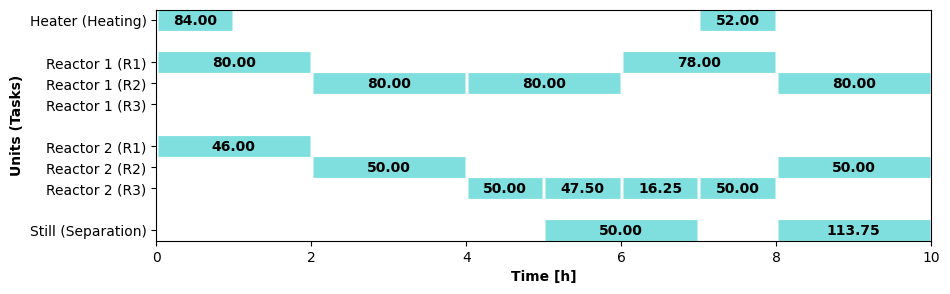

In [9]:
#Visualise solution in Gantt chart
plt.figure(figsize=(10,3))

#Gap between bars
bargap = 1/500*H
#Initialisation
marks = []
lbls = []
idp = 1
for j in sorted(J):
    idp = idp - 1
    for i in sorted(Ij[j]):
        idp = idp - 1
        #Marks and titles
        marks.append(idp)
        lbls.append("{0:s} ({1:s})".format(j,i))
        for t in T:
            if model.W[i,j,t]() > 0:
                #Gantt chart bar
                plt.plot([t+bargap,t+tau[i]-bargap], [idp,idp],alpha=.5,color='c', lw=15, solid_capstyle='butt')
                #Gantt chart text
                txt = "{0:.2f}".format(model.B[i,j,t]())
                plt.text(t+tau[i]/2, idp, txt, color='k', weight='bold', ha='center', va='center')
#Axis formatting
plt.xlim(0,H)
plt.xlabel("Time [h]", fontweight='bold')
plt.ylabel("Units (Tasks)", fontweight='bold')
plt.gca().set_yticks(marks)
plt.gca().set_yticklabels(lbls);

## Visualisation of Documented Data (Supplementary)

In the same way, the documented data can be visualised in the same format by first manually entering the article data, which is what is done in the following code:

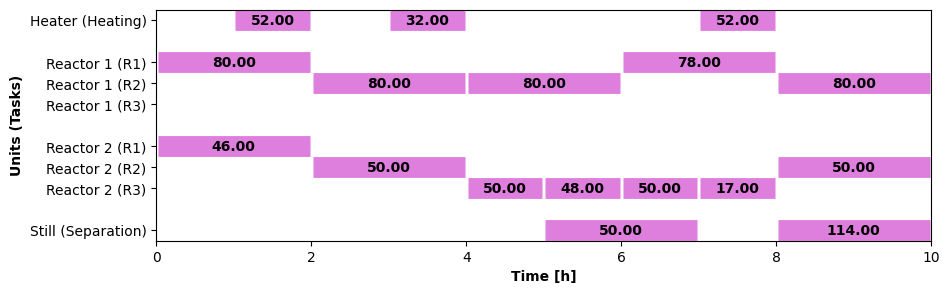

In [10]:
# VISUALISATION OF DOCUMENTED EXAMPLE DATA

# Setup literature data
Wart = np.zeros((len(I),len(J),len(T)))
Bart = np.zeros((len(I),len(J),len(T)))
#Heater
Wart[0,0,1] = 1; Bart[0,0,1] = 52;
Wart[0,0,3] = 1; Bart[0,0,3] = 32;
Wart[0,0,7] = 1; Bart[0,0,7] = 52;
#Reactor 1
Wart[1,1,0] = 1; Bart[1,1,0] = 80;
Wart[2,1,2] = 1; Bart[2,1,2] = 80;
Wart[2,1,4] = 1; Bart[2,1,4] = 80;
Wart[1,1,6] = 1; Bart[1,1,6] = 78;
Wart[2,1,8] = 1; Bart[2,1,8] = 80;
#Reactor 2
Wart[1,2,0] = 1; Bart[1,2,0] = 46;
Wart[2,2,2] = 1; Bart[2,2,2] = 50;
Wart[3,2,4] = 1; Bart[3,2,4] = 50;
Wart[3,2,5] = 1; Bart[3,2,5] = 48;
Wart[3,2,6] = 1; Bart[3,2,6] = 50;
Wart[3,2,7] = 1; Bart[3,2,7] = 17;
Wart[2,2,8] = 1; Bart[2,2,8] = 50;
#Still
Wart[4,3,5] = 1; Bart[4,3,5] = 50;
Wart[4,3,8] = 1; Bart[4,3,8] = 114;

#Visualise solution in Gantt chart
plt.figure(figsize=(10,3))

bargap = 1/500*H
marks = []
lbls = []
idp = 1
iart = 0; jart = 0;
for j in sorted(J):
    if j == 'Heater':
        iart = 0
    elif j == 'Reactor 1' or j == 'Reactor 2':
        iart = 1
    elif j == 'Still':
        iart = 4
    idp = idp - 1
    for i in sorted(Ij[j]):
        idp = idp - 1
        marks.append(idp)
        lbls.append("{0:s} ({1:s})".format(j,i))
        for t in T:
            if Wart[iart,jart,t] > 0:
                plt.plot([t+bargap,t+tau[i]-bargap], [idp,idp],alpha=.5,color='m', lw=15, solid_capstyle='butt')
                txt = "{0:.2f}".format(Bart[iart,jart,t])
                plt.text(t+tau[i]/2, idp, txt, color='k', weight='bold', ha='center', va='center')
        iart = iart + 1
    jart = jart + 1
plt.xlim(0,H)
plt.xlabel("Time [h]", fontweight='bold')
plt.ylabel("Units (Tasks)", fontweight='bold')
plt.gca().set_yticks(marks)
plt.gca().set_yticklabels(lbls);